<a href="https://colab.research.google.com/github/jaisidhsingh/ComputerVisionPython/blob/main/mask_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

  

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteFCMRC1/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteFCMRC1/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
train_len = info.splits['train'].num_examples
batch_size = 64
buffer_size = 1000
steps_per_epoch = train_len // batch_size


In [5]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_data = train.cache().shuffle(buffer_size).batch(batch_size).repeat()
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test.batch(batch_size)



In [6]:
for iamge, mask in train_data.take(1):
  print(iamge.shape)
  print(mask.shape)

(64, 128, 128, 3)
(64, 128, 128, 1)


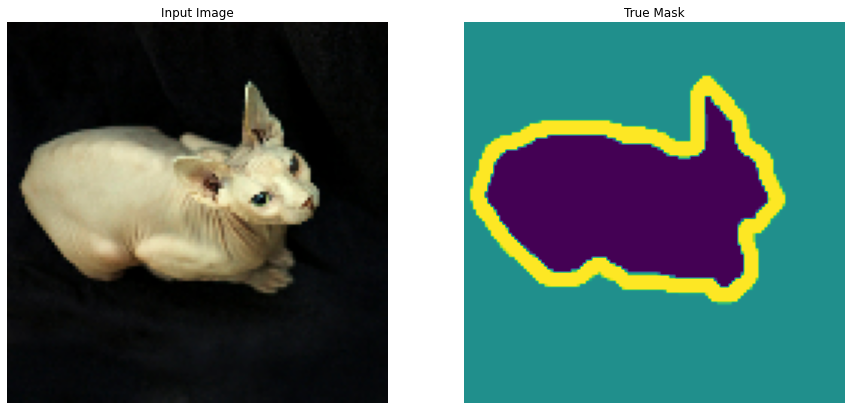

(128, 128, 3)
(128, 128, 1)


In [7]:
def display(disp_param):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(disp_param)):
    plt.subplot(1, len(disp_param), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(disp_param[i]))
    plt.axis('off')
  plt.show()




for image, mask in train.take(1):
  i, m = image, mask
display([i, m])
print(i.shape)
print(m.shape)

In [8]:
output_channels = 3

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_ref = [
             'block_1_expand_relu', #64x64
             'block_3_expand_relu', #32x32
             'block_6_expand_relu', #16x16
             'block_13_expand_relu', #8x8
             'block_16_project', #4x4
]

layers = [base_model.get_layer(item).output for item in layer_ref]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [9]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [10]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  hops = down_stack(x)
  x = hops[-1]
  hops = reversed(hops[:-1])

  for up, hop in zip(up_stack, hops):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, hop])

  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [11]:
model = unet_model(output_channels)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

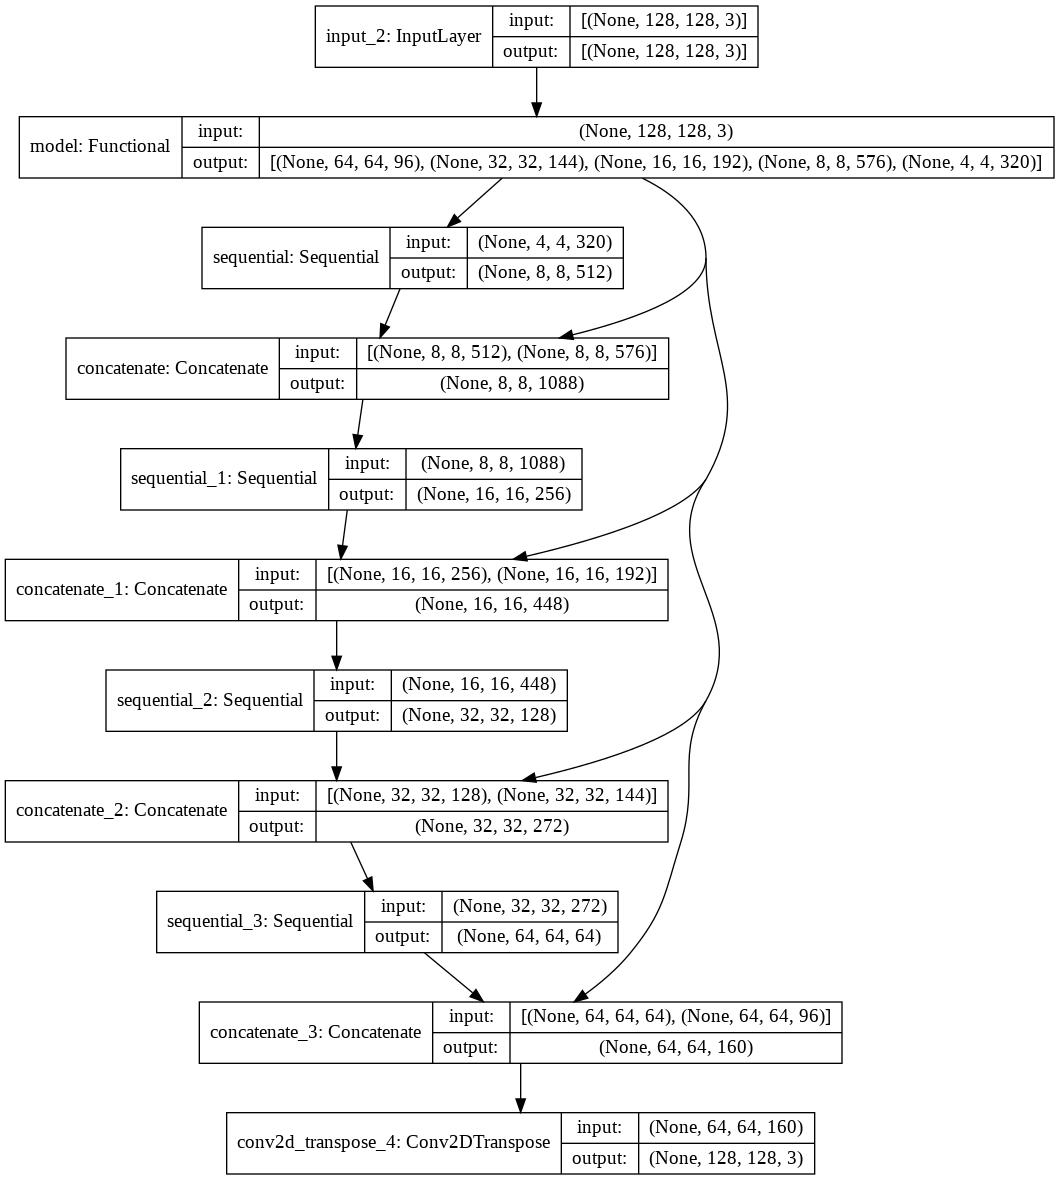

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [29]:
def createMask(mask_pred):
  mask_pred = tf.argmax(mask_pred, axis=-1)
  mask_pred = mask_pred[..., tf.newaxis]
  return mask_pred[0]

def predict(data=None, pick=1):
  if data:
    for image, mask in data.take(pick):
      pred_mask = model.predict(image)
      display([image[0], mask[0], createMask(pred_mask)])
  else:
    display([i, m, createMask(model.predict(i[tf.newaxis, ...]))])



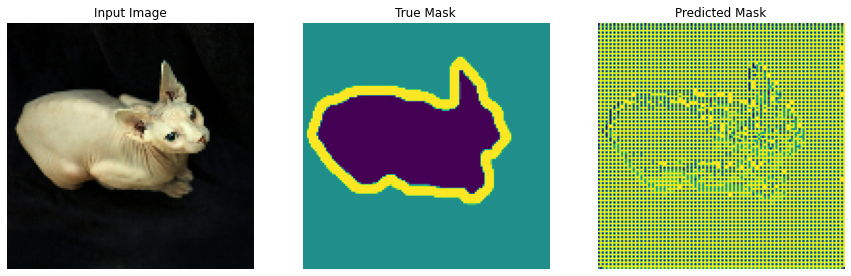

In [19]:
predict()

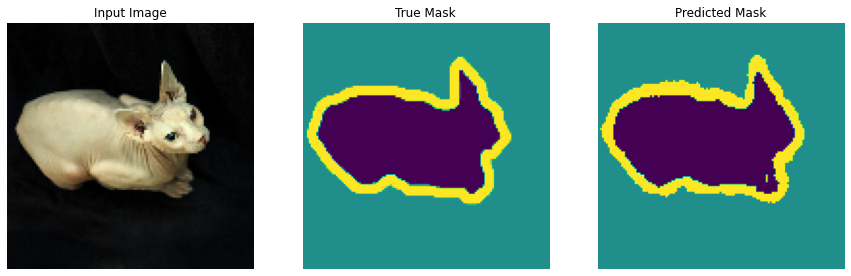


Sample Prediction after epoch 20



In [25]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    predict()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//batch_size//VAL_SUBSPLITS

model_history = model.fit(train_data, epochs=EPOCHS,
                          steps_per_epoch=steps_per_epoch,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_data,
                          callbacks=[DisplayCallback()])



In [26]:
score = model.evaluate(test_data)
loss = score[0]
acc = score[1]

print(loss, acc*100, "%")

58/58 [==============================] - 12s 203ms/step - loss: 0.3284 - accuracy: 0.8900
0.32837948203086853 88.99601101875305 %


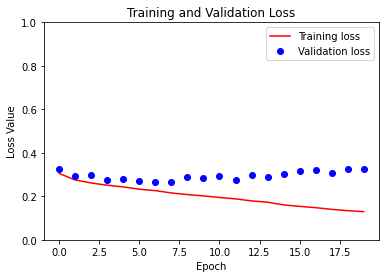

In [27]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

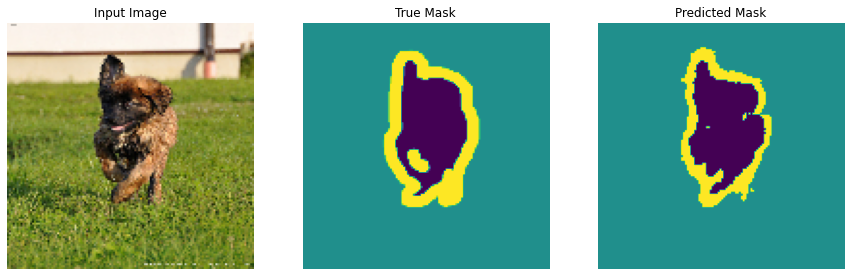

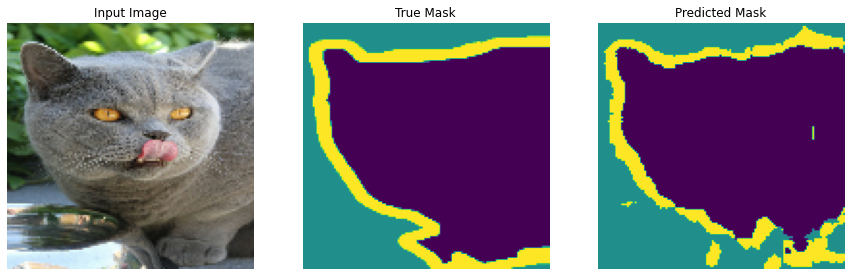

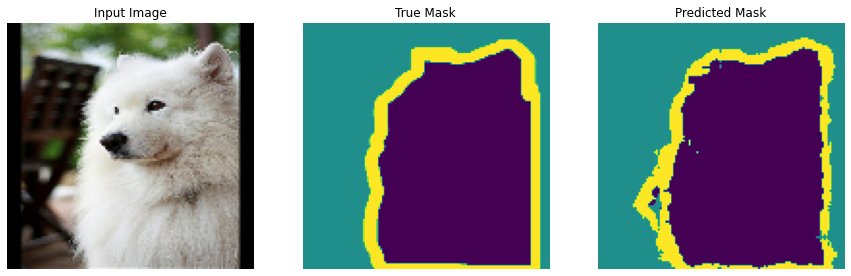

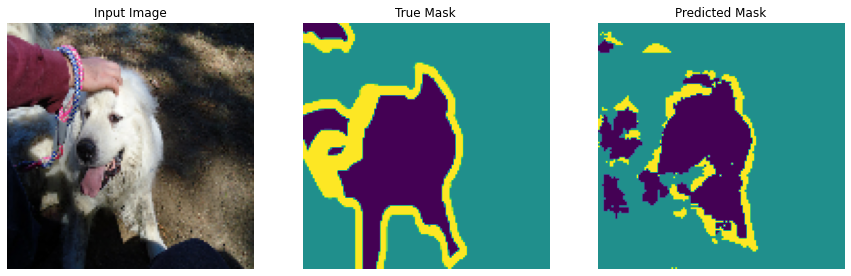

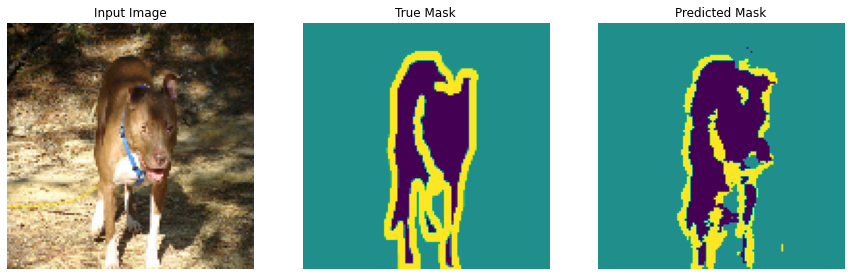

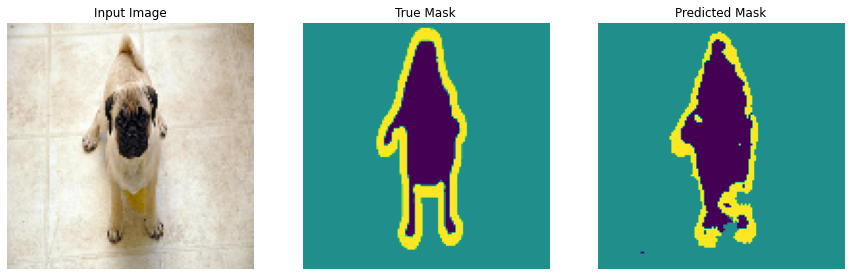

In [30]:
predict(test_data, 6)

In [ ]:
#:)